# Transfer learning with disease and non disease data



### Import tensorflow

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


### Import modules and download the diseases and none diseases dataset.

In [2]:
import urllib.request
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile




In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

# Set the path to your desired directory
new_directory_path = '/content/drive/MyDrive/moffitt/'

# Change the current working directory
os.chdir(new_directory_path)


In [ ]:
data_file_name = "moffitt.zip"
download_dir = '/tmp/'
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()


KeyboardInterrupt



Check that the dataset has the expected number of examples.

Create some folders that will store the training and test data.
- There will be a training folder and a testing folder.
- Each of these will have a subfolder for diseases and another subfolder for none diseases.

### Split data into training and test sets

- The following code put first checks if an image file is empty (zero length)
- Of the files that are not empty, it puts 90% of the data into the training set, and 10% into the test set.

In [ ]:
import random
from shutil import copyfile
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


DISEASES_SOURCE_DIR = "/tmp/moffitt/classify_cytology/diseases/"
TRAINING_DISEASES_DIR = "/tmp/diseases-v-nondiseases/training/diseases/"
TESTING_DISEASES_DIR = "/tmp/diseases-v-nondiseases/testing/diseases/"
NO_DISEASES_SOURCE_DIR = "/tmp/moffitt/classify_cytology/no_diseases/"
TRAINING_NO_DISEASES_DIR = "/tmp/diseases-v-nondiseases/training/non_diseases/"
TESTING_NO_DISEASES_DIR = "/tmp/diseases-v-nondiseases/testing/non_diseases/"

split_size = 0.95
split_data(DISEASES_SOURCE_DIR, TRAINING_DISEASES_DIR, TESTING_DISEASES_DIR, split_size)
split_data(NO_DISEASES_SOURCE_DIR, TRAINING_NO_DISEASES_DIR, TESTING_NO_DISEASES_DIR, split_size)
print("Number of images:",len(os.listdir('/tmp/diseases-v-nondiseases/training/')))


Number of images: 2


In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Set your source and destination directories
source_directory = '/tmp/diseases-v-nondiseases/testing/'
destination_directory = '/content/drive/MyDrive/moffitt/testing1/'

# Copy files from source to destination
shutil.copytree(source_directory, destination_directory)

# Repeat for the training directory
source_directory = '/tmp/diseases-v-nondiseases/training/'
destination_directory = '/content/drive/MyDrive/moffitt/training1/'

shutil.copytree(source_directory, destination_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/moffitt/training1/'

In [ ]:
print("Number of training diseases images", len(os.listdir('/content/drive/MyDrive/moffitt/training/diseases/')))
print("Number of training no diseases images", len(os.listdir('/content/drive/MyDrive/moffitt/training/non_diseases/')))
print("Number of testing diseases images", len(os.listdir('/content/drive/MyDrive/moffitt/testing/diseases/')))
print("Number of testing no diseases images", len(os.listdir('/content/drive/MyDrive/moffitt/testing/non_diseases/')))

Number of training diseases images 1382
Number of training no diseases images 1517
Number of testing diseases images 76
Number of testing no diseases images 160


In [ ]:
import os
import pandas as pd

# Directories
TRAINING_DISEASES_DIR = "/content/drive/MyDrive/moffitt/training/diseases/"

# Function to get image paths and labels
def get_image_paths_and_labels(directory, label):
  image_paths = [img for img in os.listdir(directory)]
  labels = [label] * len(image_paths)
  return image_paths, labels

# Creating DataFrame for diseases
diseases_train_paths, diseases_train_labels = get_image_paths_and_labels(TRAINING_DISEASES_DIR, label="Disease")
diseases_df = pd.DataFrame({'Image_Path': diseases_train_paths,
                            'Label': diseases_train_labels})



# Save the DataFrame to the same directory as training
output_df_path = os.path.join("/content/drive/MyDrive/moffitt/", "diseases_df.csv")
diseases_df.to_csv(output_df_path, index=False)
# Display the DataFrame
print(diseases_df)


           Image_Path    Label
0     di8_img_023.jpg  Disease
1     di2_img_125.jpg  Disease
2     di2_img_196.jpg  Disease
3     di6_img_111.jpg  Disease
4     di8_img_180.jpg  Disease
...               ...      ...
1377  di6_img_105.jpg  Disease
1378  di6_img_135.jpg  Disease
1379  di6_img_057.jpg  Disease
1380  di2_img_202.jpg  Disease
1381  di3_img_077.jpg  Disease

[1382 rows x 2 columns]


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image

def load_image(image_path):
    return Image.open(image_path)

def create_image_grid(images, labels, grid_size=(10, 10), image_size=(64, 64)):
    fig = plt.figure(figsize=(20, 20))
    gs = gridspec.GridSpec(grid_size[0], grid_size[1], wspace=0.1, hspace=0.1)

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            ax = plt.subplot(gs[i, j])
            ax.imshow(images[i * grid_size[1] + j])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('auto')
            ax.set_title(labels[i * grid_size[1] + j])

    plt.show()

def display_image_grid(directory, csv_path, grid_size=(10, 10), image_size=(64, 64)):
    # Load CSV file with labels
    full_df = pd.read_csv(csv_path)
    full_df = full_df.sample(frac=1).reset_index(drop=True)

    # Load images and labels
    images = []
    labels = []
    for index, row in full_df.iterrows():
        image_path = os.path.join(directory, row['Image_Path'])
        image = load_image(image_path)
        image = image.resize(image_size)  # Resize image if necessary
        images.append(image)
        labels.append(row['Label'])

    # Create and display the image grid
    create_image_grid(images, labels, grid_size, image_size)

# Example usage
TRAINING_DISEASES_DIR = "/content/drive/MyDrive/moffitt/training/diseases/"
CSV_PATH = "/content/drive/MyDrive/moffitt/diseases_df.csv"
display_image_grid(TRAINING_DISEASES_DIR, CSV_PATH)

KeyboardInterrupt: 

In [ ]:
import os
import pandas as pd

# Directories
TRAINING_NO_DISEASES_DIR = "/content/drive/MyDrive/moffitt/training/non_diseases/"

# Function to get image paths and labels
def get_image_paths_and_labels(directory, label):
  image_paths = [img for img in os.listdir(directory)]
  labels = [label] * len(image_paths)
  return image_paths, labels

# Creating DataFrame for no diseases
no_diseases_train_paths, no_diseases_train_labels = get_image_paths_and_labels(TRAINING_NO_DISEASES_DIR, label="No Disease")
no_diseases_df = pd.DataFrame({'Image_Path': no_diseases_train_paths ,
                               'Label': no_diseases_train_labels })



# Save the DataFrame to the same directory as training
output_df_path = os.path.join("/content/drive/MyDrive/moffitt/", "no_diseases_df.csv")
no_diseases_df.to_csv(output_df_path, index=False)
# Display the DataFrame
print(no_diseases_df)

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image

def load_image(image_path):
    return Image.open(image_path)

def create_image_grid(images, labels, grid_size=(10, 10), image_size=(64, 64)):
    fig = plt.figure(figsize=(20, 20))
    gs = gridspec.GridSpec(grid_size[0], grid_size[1], wspace=0.1, hspace=0.1)

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            ax = plt.subplot(gs[i, j])
            ax.imshow(images[i * grid_size[1] + j])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('auto')
            ax.set_title(labels[i * grid_size[1] + j])

    plt.show()

def display_image_grid(directory, csv_path, grid_size=(10, 10), image_size=(64, 64)):
    # Load CSV file with labels
    full_df = pd.read_csv(csv_path)
    full_df = full_df.sample(frac=1).reset_index(drop=True)

    # Load images and labels
    images = []
    labels = []
    for index, row in full_df.iterrows():
        image_path = os.path.join(directory, row['Image_Path'])
        image = load_image(image_path)
        image = image.resize(image_size)  # Resize image if necessary
        images.append(image)
        labels.append(row['Label'])

    # Create and display the image grid
    create_image_grid(images, labels, grid_size, image_size)

# Example usage
TRAINING_DISEASES_DIR = "/content/drive/MyDrive/moffitt/training/non_diseases/"
CSV_PATH = "/content/drive/MyDrive/moffitt/no_diseases_df.csv"
display_image_grid(TRAINING_DISEASES_DIR, CSV_PATH)

In [ ]:
import os
import pandas as pd

# Directories
TRAINING_DISEASES_DIR = "/content/drive/MyDrive/moffitt/training/diseases/"
TRAINING_NO_DISEASES_DIR = "/content/drive/MyDrive/moffitt/training/non_diseases/"

# Function to get image paths and labels
def get_image_paths_and_labels(directory, label):
  if label=="Disease":
    image_paths = [img for img in os.listdir(directory)]
  else:
    image_paths = [img for img in os.listdir(directory)]
  labels = [label] * len(image_paths)
  return image_paths, labels

# Creating DataFrame for diseases
diseases_train_paths, diseases_train_labels = get_image_paths_and_labels(TRAINING_DISEASES_DIR, label="Disease")
diseases_df = pd.DataFrame({'Image_Path': diseases_train_paths,
                            'Label': diseases_train_labels})

# Creating DataFrame for no diseases
no_diseases_train_paths, no_diseases_train_labels = get_image_paths_and_labels(TRAINING_NO_DISEASES_DIR, label="No Disease")
no_diseases_df = pd.DataFrame({'Image_Path': no_diseases_train_paths ,
                               'Label': no_diseases_train_labels })

# Concatenating both DataFrames
full_df2 = pd.concat([diseases_df, no_diseases_df], ignore_index=True)
# Save the DataFrame to the same directory as training
output_df_path = os.path.join("/content/drive/MyDrive/moffitt/", "full_df.csv")
full_df2.to_csv(output_df_path, index=False)
# Display the DataFrame
print(full_df2)



             Image_Path       Label
0       di8_img_023.jpg     Disease
1       di2_img_125.jpg     Disease
2       di2_img_196.jpg     Disease
3       di6_img_111.jpg     Disease
4       di8_img_180.jpg     Disease
...                 ...         ...
2894  nodi7_img_164.jpg  No Disease
2895   nodi_img_099.jpg  No Disease
2896  nodi5_img_132.jpg  No Disease
2897  nodi7_img_182.jpg  No Disease
2898  nodi2_img_002.jpg  No Disease

[2899 rows x 2 columns]


Check that the training and test sets are the expected lengths.

### K fold cross validation

In [ ]:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from PIL import Image

%matplotlib inline
from keras.applications import ResNet50,ResNet101
import cv2
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import applications
from keras.models import Model
from keras import optimizers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.preprocessing import image

In [ ]:
from sklearn.model_selection import StratifiedKFold , KFold ,RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/moffitt/full_df.csv')
train.head(-5)

Image_Path       Label
0       di8_img_023.jpg     Disease
1       di2_img_125.jpg     Disease
2       di2_img_196.jpg     Disease
3       di6_img_111.jpg     Disease
4       di8_img_180.jpg     Disease
...                 ...         ...
2889  nodi4_img_091.jpg  No Disease
2890  nodi2_img_168.jpg  No Disease
2891  nodi3_img_046.jpg  No Disease
2892  nodi5_img_179.jpg  No Disease
2893  nodi7_img_027.jpg  No Disease

[2894 rows x 2 columns]

In [ ]:
df = train.copy()

In [ ]:
print(len(df))

2899


In [ ]:
Disease = train[train["Label"]=='Disease']
No_Disease = train[train["Label"]=='No Disease']


df = pd.concat([df,Disease])
df = pd.concat([df,No_Disease])


df = df.sample(frac=1).reset_index(drop=True)
df.head()
print(len(df))

11596


In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/moffitt/combined_training/'

In [ ]:
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping

def get_model(IMG_SIZE):
    base_model =applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    add_model = Sequential()
    add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    add_model.add(BatchNormalization())
    add_model.add(Dense(256, activation='relu'))
    add_model.add(Dropout(0.2))
    add_model.add(Dense(128, activation='relu'))
    add_model.add(Dropout(0.2))
    add_model.add(Dense(64, activation='relu'))
    add_model.add(Dropout(0.2))
    add_model.add(Dense(2, activation='sigmoid'))

    model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
                  metrics=['accuracy'])
    return model
#     model.summary()

In [ ]:
# Storing the average of all predictions

main_pred = []
data_kfold = pd.DataFrame()

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Creating X, Y for training

train_y = df.Label
train_x = df.drop(['Label'],axis=1)

In [ ]:
print(train_y)
print(train_x)

0          Disease
1       No Disease
2          Disease
3       No Disease
4       No Disease
           ...    
2894    No Disease
2895       Disease
2896       Disease
2897       Disease
2898       Disease
Name: Label, Length: 2899, dtype: object
             Image_Path
0       di2_img_203.jpg
1     nodi2_img_161.jpg
2      di12_img_040.jpg
3      nodi_img_178.jpg
4     nodi3_img_165.jpg
...                 ...
2894  nodi4_img_058.jpg
2895    di6_img_319.jpg
2896   di16_img_032.jpg
2897    di8_img_065.jpg
2898    di3_img_055.jpg

[2899 rows x 1 columns]


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 20
EPOCHS = 5
N_SPLIT = 10


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 20
EPOCHS = 10
N_SPLIT = 10

Found 10436 validated image filenames belonging to 2 classes.
Found 1160 validated image filenames belonging to 2 classes.


<ipython-input-80-953e2ac2492f>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_test.fit_generator(


Epoch 1/5
521/521 [==============================] - 724s 1s/step - loss: 0.1990 - accuracy: 0.9460 - val_loss: 19.4427 - val_accuracy: 0.5233
Epoch 2/5
521/521 [==============================] - 662s 1s/step - loss: 0.0588 - accuracy: 0.9832 - val_loss: 0.3711 - val_accuracy: 0.7690
Epoch 3/5
521/521 [==============================] - 651s 1s/step - loss: 0.0340 - accuracy: 0.9902 - val_loss: 4.7806 - val_accuracy: 0.6517
Epoch 4/5
521/521 [==============================] - 664s 1s/step - loss: 0.0285 - accuracy: 0.9921 - val_loss: 7.2509 - val_accuracy: 0.7690
Epoch 5/5
521/521 [==============================] - 674s 1s/step - loss: 0.0131 - accuracy: 0.9961 - val_loss: 0.4025 - val_accuracy: 0.9405


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


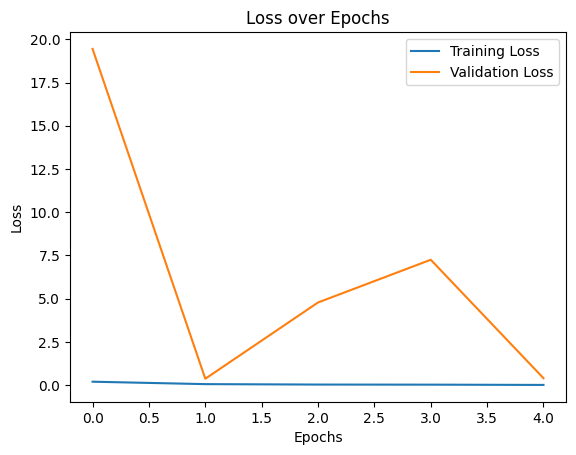

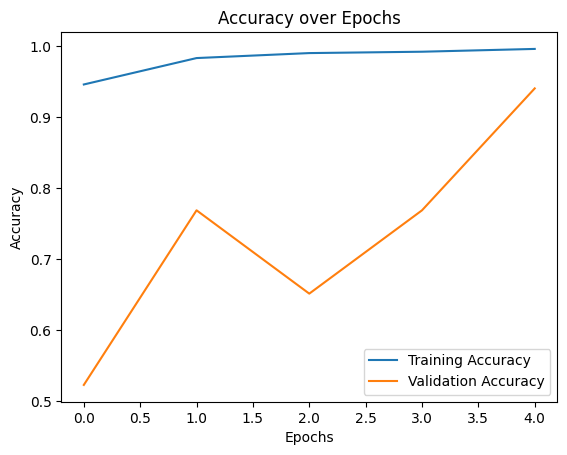

Found 10436 validated image filenames belonging to 2 classes.
Found 1160 validated image filenames belonging to 2 classes.


<ipython-input-80-953e2ac2492f>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_test.fit_generator(


Epoch 1/5
521/521 [==============================] - 726s 1s/step - loss: 8.6971 - accuracy: 0.7379 - val_loss: 0.6921 - val_accuracy: 0.5233
Epoch 2/5
521/521 [==============================] - 670s 1s/step - loss: nan - accuracy: 0.4972 - val_loss: nan - val_accuracy: 0.4767
Epoch 3/5
521/521 [==============================] - 682s 1s/step - loss: nan - accuracy: 0.4767 - val_loss: nan - val_accuracy: 0.4767
Epoch 4/5
521/521 [==============================] - 676s 1s/step - loss: nan - accuracy: 0.4764 - val_loss: nan - val_accuracy: 0.4767


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


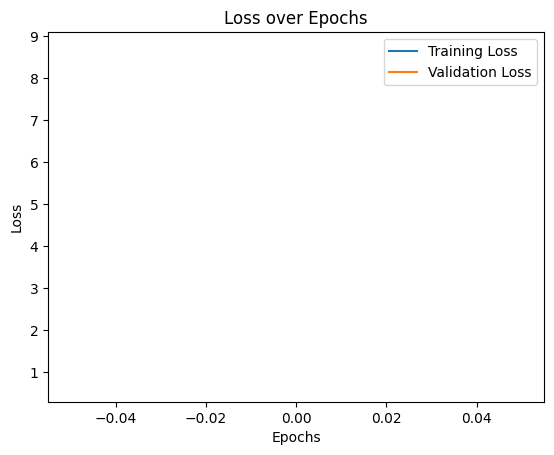

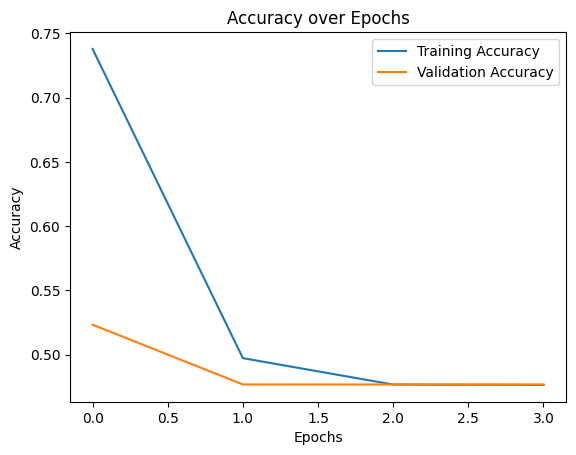

Found 10436 validated image filenames belonging to 2 classes.
Found 1160 validated image filenames belonging to 2 classes.


<ipython-input-80-953e2ac2492f>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_test.fit_generator(


Epoch 1/5
521/521 [==============================] - 697s 1s/step - loss: 0.2995 - accuracy: 0.9299 - val_loss: 65.2027 - val_accuracy: 0.5233
Epoch 2/5
521/521 [==============================] - 672s 1s/step - loss: 1.3931 - accuracy: 0.8942 - val_loss: 0.7675 - val_accuracy: 0.4767
Epoch 3/5
521/521 [==============================] - 713s 1s/step - loss: 1.4857 - accuracy: 0.5218 - val_loss: 0.6921 - val_accuracy: 0.5233
Epoch 4/5
521/521 [==============================] - 671s 1s/step - loss: 0.8036 - accuracy: 0.5200 - val_loss: 0.6931 - val_accuracy: 0.5233
Epoch 5/5
521/521 [==============================] - 670s 1s/step - loss: nan - accuracy: 0.5182 - val_loss: nan - val_accuracy: 0.4767


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


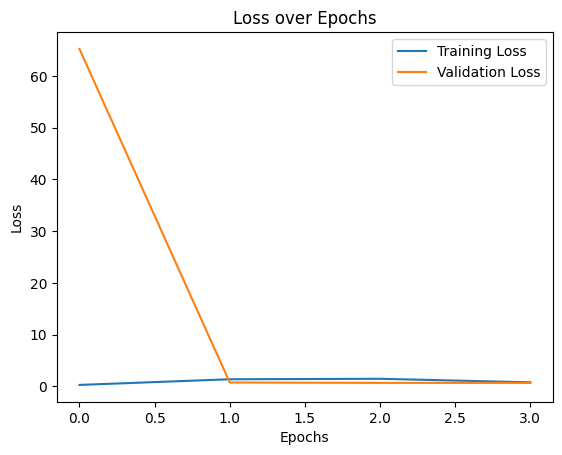

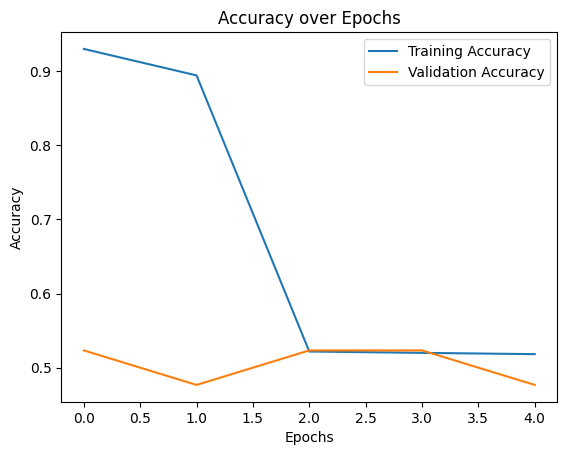

Found 10436 validated image filenames belonging to 2 classes.
Found 1160 validated image filenames belonging to 2 classes.


<ipython-input-80-953e2ac2492f>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_test.fit_generator(


Epoch 1/5
521/521 [==============================] - 679s 1s/step - loss: 0.1498 - accuracy: 0.9542 - val_loss: 6.6677 - val_accuracy: 0.5233
Epoch 2/5
521/521 [==============================] - 663s 1s/step - loss: 0.0400 - accuracy: 0.9880 - val_loss: 1.3663 - val_accuracy: 0.8603
Epoch 3/5
521/521 [==============================] - 666s 1s/step - loss: 0.0271 - accuracy: 0.9912 - val_loss: 29.4931 - val_accuracy: 0.4767
Epoch 4/5
521/521 [==============================] - 671s 1s/step - loss: 0.0128 - accuracy: 0.9961 - val_loss: 0.2658 - val_accuracy: 0.9362
Epoch 5/5
521/521 [==============================] - 655s 1s/step - loss: 0.0201 - accuracy: 0.9938 - val_loss: 1.3319 - val_accuracy: 0.7957


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


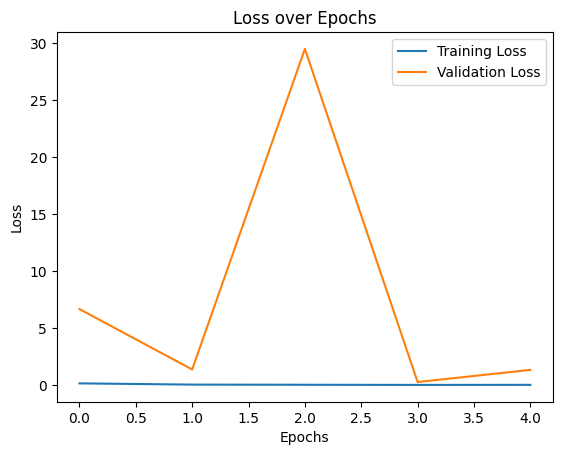

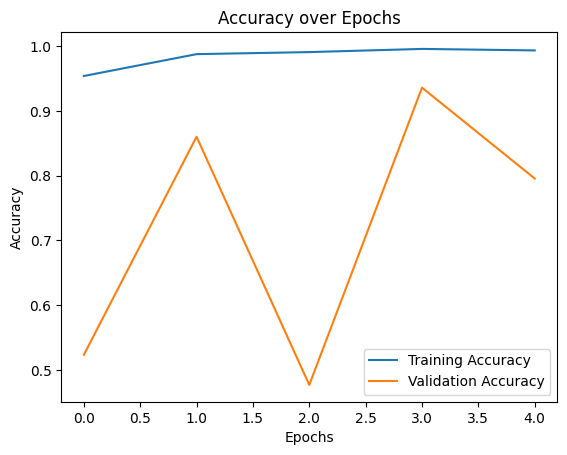

Found 10436 validated image filenames belonging to 2 classes.
Found 1160 validated image filenames belonging to 2 classes.


<ipython-input-80-953e2ac2492f>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_test.fit_generator(


Epoch 1/5
521/521 [==============================] - 666s 1s/step - loss: 0.1490 - accuracy: 0.9538 - val_loss: 5.8740 - val_accuracy: 0.5233
Epoch 2/5
521/521 [==============================] - 654s 1s/step - loss: 0.0555 - accuracy: 0.9824 - val_loss: 2.0838 - val_accuracy: 0.7707
Epoch 3/5
165/521 [========>.....................] - ETA: 6:58 - loss: 0.0364 - accuracy: 0.9848

KeyboardInterrupt: 

In [ ]:
from keras.callbacks import EarlyStopping

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)
# Specify the directory to save the models
save_dir = '/content/drive/MyDrive/moffitt/model4/'

# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

kfold = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=42)

for train_idx, val_idx in list(kfold.split(train_x, train_y)):
    x_train_df = df.iloc[train_idx]
    x_valid_df = df.iloc[val_idx]

    training_set = train_datagen.flow_from_dataframe(dataframe=x_train_df, directory=TRAIN_PATH,
                                                     x_col="Image_Path", y_col="Label",
                                                     class_mode="categorical",
                                                     target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

    validation_set = validation_datagen.flow_from_dataframe(dataframe=x_valid_df, directory=TRAIN_PATH,
                                                           x_col="Image_Path", y_col="Label",
                                                           class_mode="categorical",
                                                           target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

    model_test = get_model(IMG_SIZE)

    # EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Model training
    history = model_test.fit_generator(
        training_set,
        validation_data=validation_set,
        epochs=EPOCHS,
        steps_per_epoch=x_train_df.shape[0] // BATCH_SIZE,
        callbacks=[early_stopping]  # Add the EarlyStopping callback
    )

    # Explicitly retrieve the model with the best weights
    best_weights_model = get_model(IMG_SIZE)
    best_weights_model.set_weights(model_test.get_weights())

    # Save the model if needed
    best_weights_model.save(f"{save_dir}model_{j}.h5")

    # Plot loss and accuracy
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    j += 1

In [ ]:
import os
import pandas as pd

# Directories
TESTING_DISEASES_DIR = "/content/drive/MyDrive/moffitt/testing/diseases/"
TESTING_NO_DISEASES_DIR = "/content/drive/MyDrive/moffitt/testing/non_diseases/"

# Function to get image paths and labels
def get_image_paths_and_labels(directory, label):
  if label=="Disease":
    image_paths = [img for img in os.listdir(directory)]
  else:
    image_paths = [img for img in os.listdir(directory)]
  labels = [label] * len(image_paths)
  return image_paths, labels

# Creating DataFrame for diseases
diseases_test_paths, diseases_test_labels = get_image_paths_and_labels(TESTING_DISEASES_DIR, label="Disease")
diseases_df = pd.DataFrame({'Image_Path': diseases_test_paths,
                            'Label': diseases_test_labels})

# Creating DataFrame for no diseases
no_diseases_test_paths, no_diseases_test_labels = get_image_paths_and_labels(TESTING_NO_DISEASES_DIR, label="No Disease")
no_diseases_df = pd.DataFrame({'Image_Path': no_diseases_test_paths ,
                               'Label': no_diseases_test_labels })

# Concatenating both DataFrames
full_df3 = pd.concat([diseases_df, no_diseases_df], ignore_index=True)
# Save the DataFrame to the same directory as training
output_df_path = os.path.join("/content/drive/MyDrive/moffitt/", "full_testing_df.csv")
full_df3.to_csv(output_df_path, index=False)
# Display the DataFrame
print(full_df3)


            Image_Path       Label
0      di6_img_299.jpg     Disease
1      di6_img_121.jpg     Disease
2      di6_img_288.jpg     Disease
3      di6_img_104.jpg     Disease
4      di2_img_018.jpg     Disease
..                 ...         ...
151   nodi_img_048.jpg  No Disease
152  nodi4_img_009.jpg  No Disease
153  nodi7_img_015.jpg  No Disease
154  nodi7_img_069.jpg  No Disease
155  nodi5_img_050.jpg  No Disease

[156 rows x 2 columns]


In [ ]:
import os
import shutil

non_diseases_directory = '/content/drive/MyDrive/moffitt/testing/non_diseases/'
diseases_directory = '/content/drive/MyDrive/moffitt/testing/diseases/'
destination_directory = '/content/drive/MyDrive/moffitt/combined_testing/'

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Copy images from non_diseases_directory
non_diseases_images = os.listdir(non_diseases_directory)
for image in non_diseases_images:
    source_path = os.path.join(non_diseases_directory, image)
    destination_path = os.path.join(destination_directory, image)
    shutil.copy(source_path, destination_path)

# Copy images from diseases_directory
diseases_images = os.listdir(diseases_directory)
for image in diseases_images:
    source_path = os.path.join(diseases_directory, image)
    destination_path = os.path.join(destination_directory, image)
    shutil.copy(source_path, destination_path)


print("Images copied successfully.")

Images copied successfully.


Found 156 validated image filenames belonging to 2 classes.
156/156 [==============================] - 12s 49ms/step
Accuracy: 0.8205
Classification Report:
               precision    recall  f1-score   support

           0       0.73      1.00      0.84        76
           1       1.00      0.65      0.79        80

    accuracy                           0.82       156
   macro avg       0.87      0.82      0.82       156
weighted avg       0.87      0.82      0.82       156



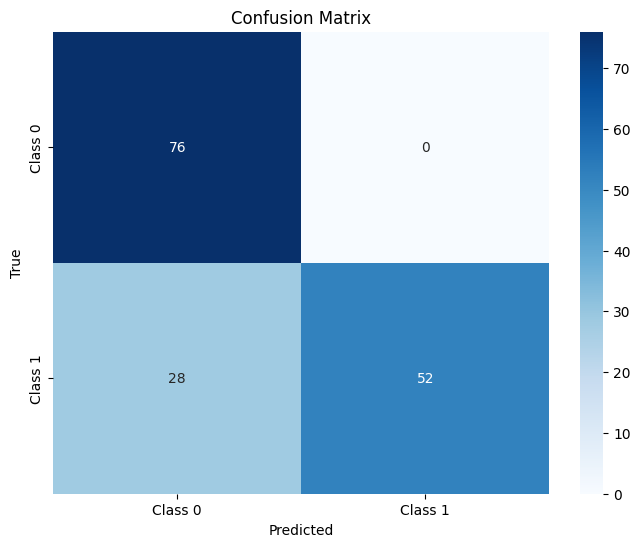

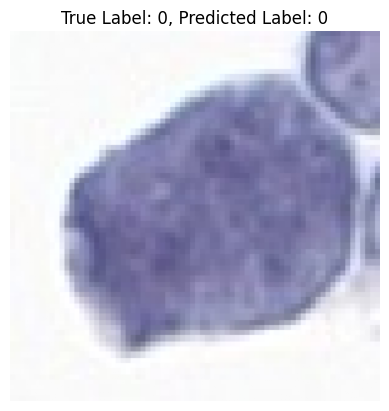

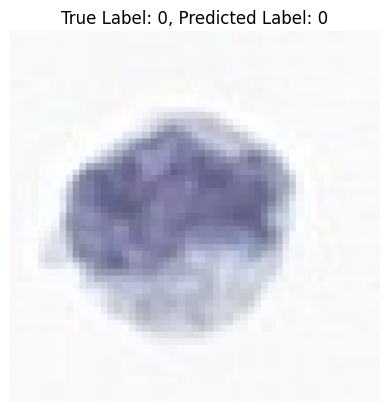

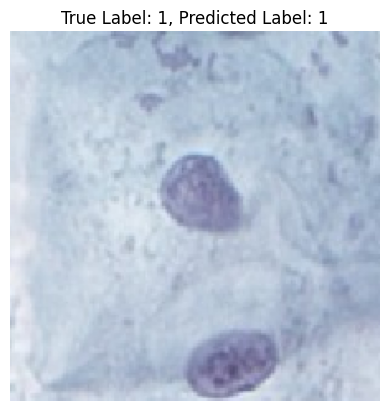

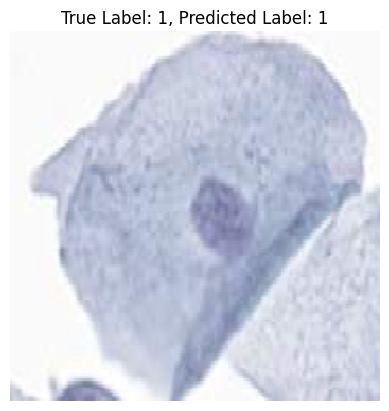

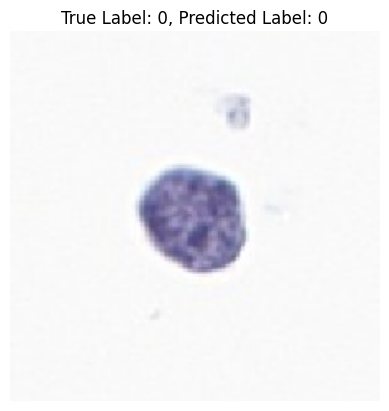

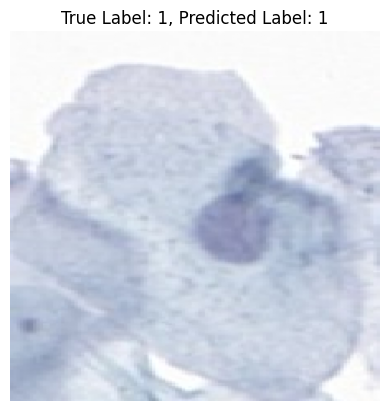

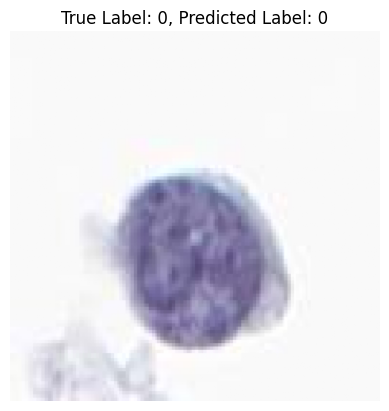

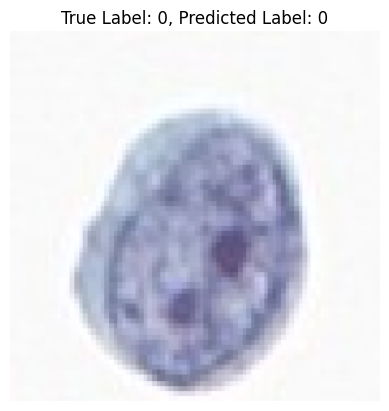

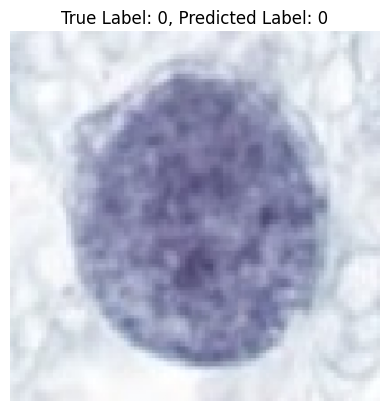

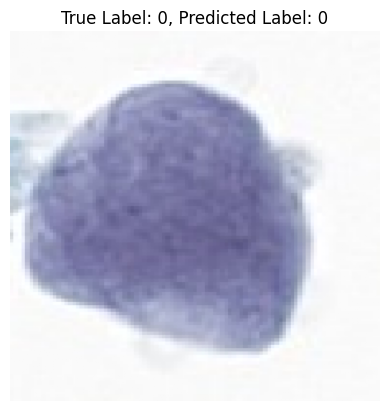

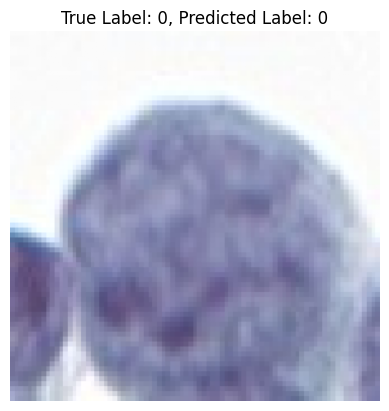

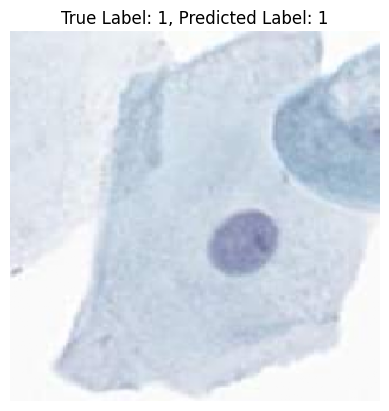

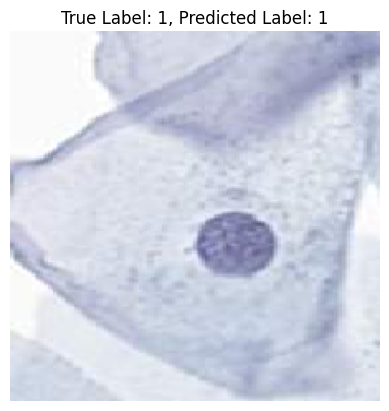

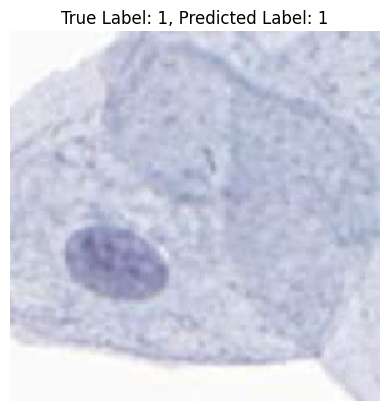

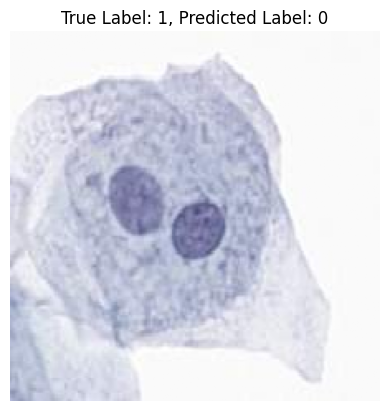

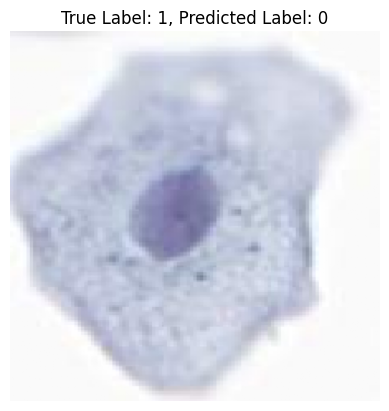

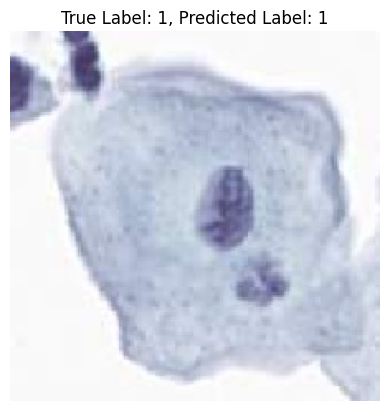

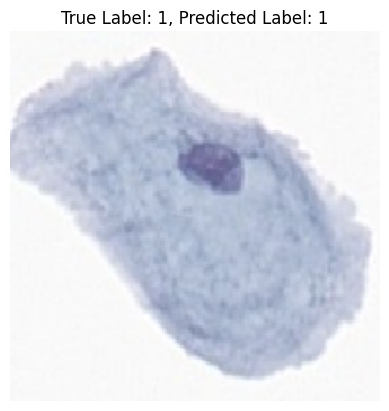

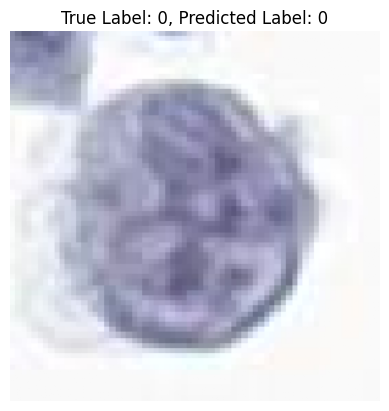

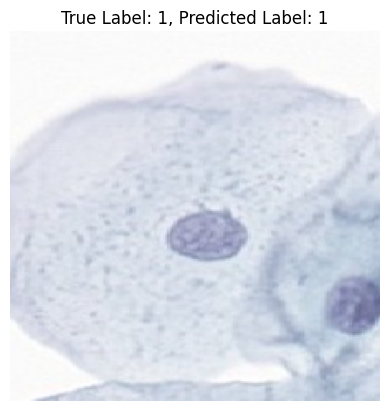

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import load_model
from keras.preprocessing import image

# Load the trained ResNet model
model_path = '/content/drive/MyDrive/moffitt/model4/model_1.h5'
model = load_model(model_path)

# Specify the testing directory
testing_dir = '/content/drive/MyDrive/moffitt/combined_testing/'

# Load the testing dataframe
full_testing_df = pd.read_csv('/content/drive/MyDrive/moffitt/full_testing_df.csv')  # Replace with the actual path

# Preprocess the testing data
test_datagen = ImageDataGenerator(rescale=1./255)
testing_set = test_datagen.flow_from_dataframe(
    dataframe=full_testing_df,
    directory=testing_dir,
    x_col="Image_Path",
    y_col="Label",
    class_mode="categorical",  # or 'binary' depending on your task
    target_size=(224, 224),  # Replace with the size used during training
    batch_size=1,
    shuffle=False  # Important: Keep the order for evaluation and confusion matrix
)

# Make predictions on the testing set
y_true = testing_set.classes
y_pred_prob = model.predict(testing_set)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate accuracy, F1 score, recall, and confusion matrix
accuracy = accuracy_score(y_true, y_pred)
classification_report_str = classification_report(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

# Print and plot the results
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report_str)

# Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Randomly pick 20 images and create a confusion matrix
random_indices = np.random.choice(len(y_true), size=20, replace=False)
random_images = [testing_set.filepaths[i] for i in random_indices]
random_labels_true = [y_true[i] for i in random_indices]
random_labels_pred = [y_pred[i] for i in random_indices]

# Display the randomly selected images with true and predicted labels
for img_path, true_label, pred_label in zip(random_images, random_labels_true, random_labels_pred):
    img = image.load_img(img_path, target_size=(224, 224))  # Replace with the size used during training
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    plt.figure()
    plt.imshow(img_array[0])
    plt.title(f'True Label: {true_label}, Predicted Label: {pred_label}')
    plt.axis('off')
    plt.show()


Found 156 validated image filenames belonging to 2 classes.
156/156 [==============================] - 7s 38ms/step
Accuracy: 0.9231
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92        76
           1       0.93      0.93      0.93        80

    accuracy                           0.92       156
   macro avg       0.92      0.92      0.92       156
weighted avg       0.92      0.92      0.92       156



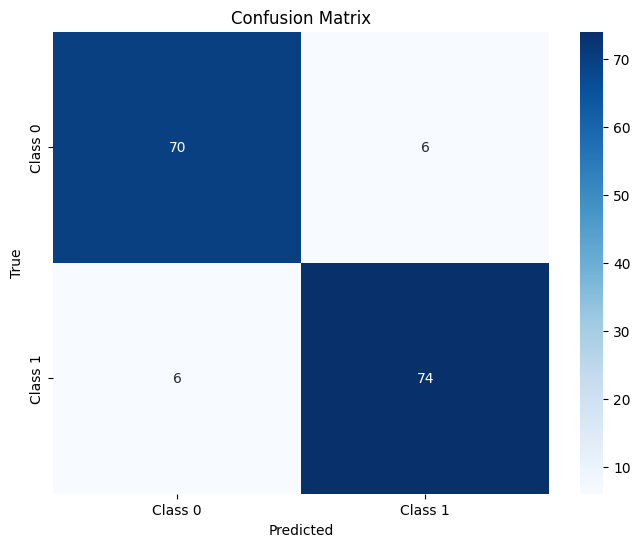

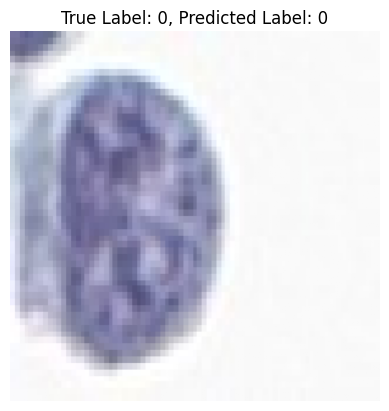

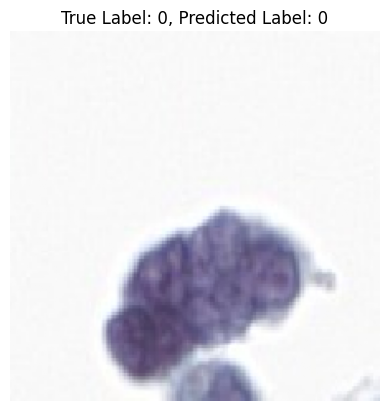

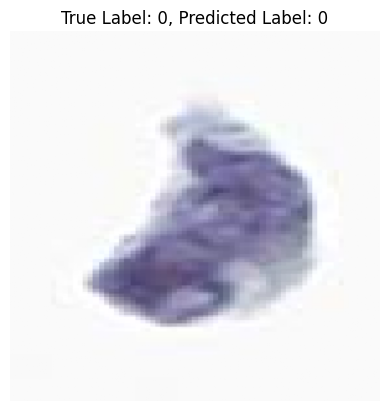

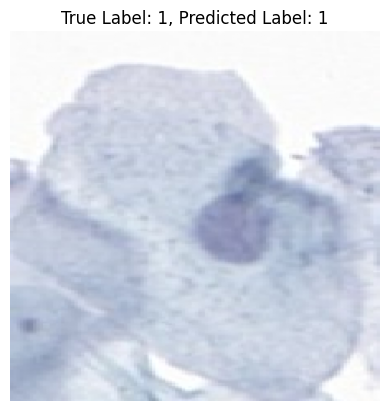

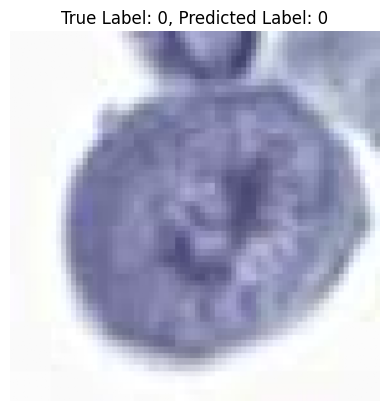

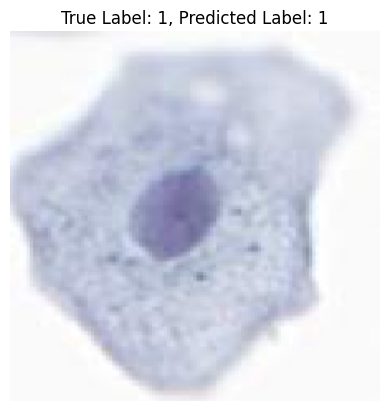

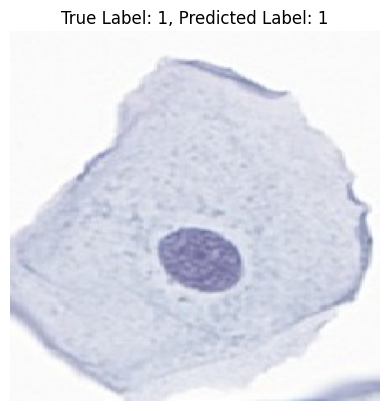

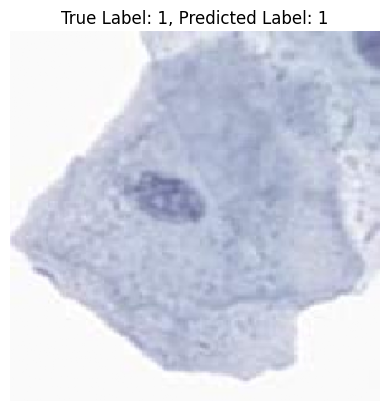

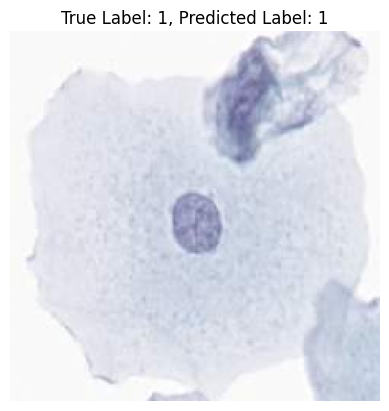

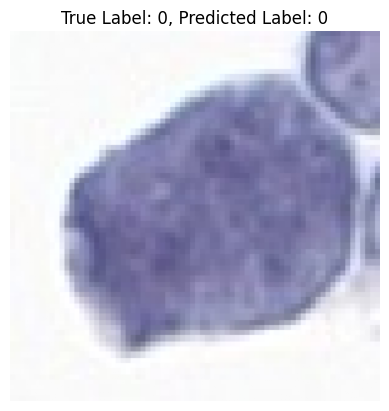

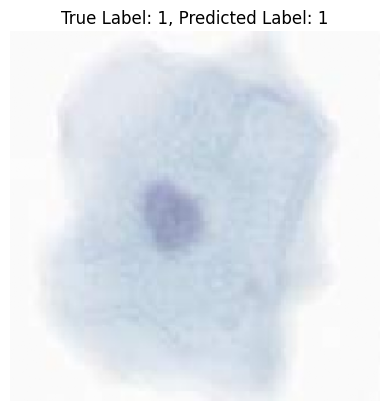

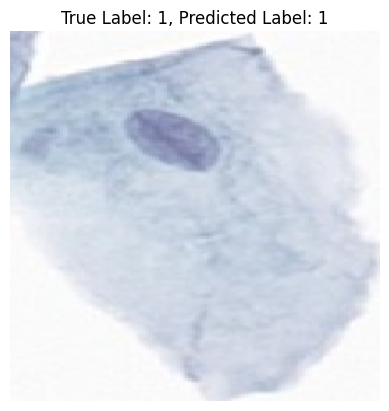

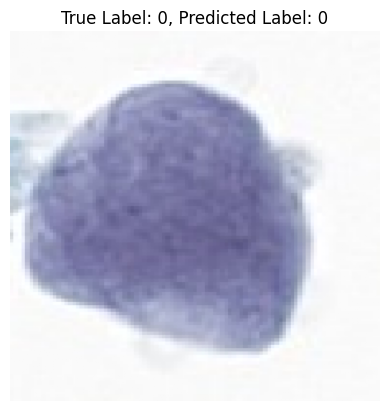

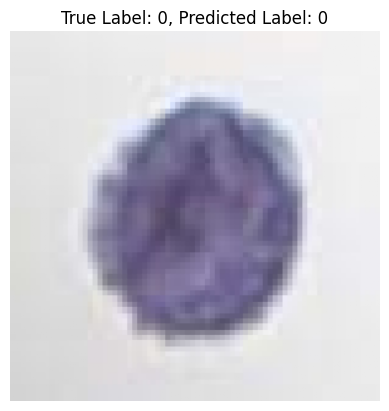

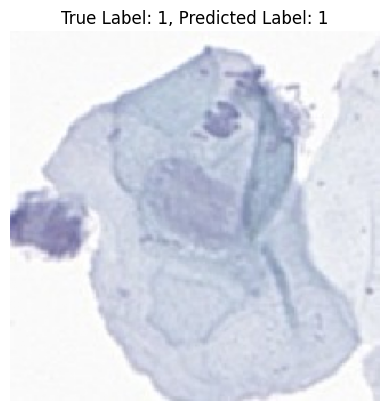

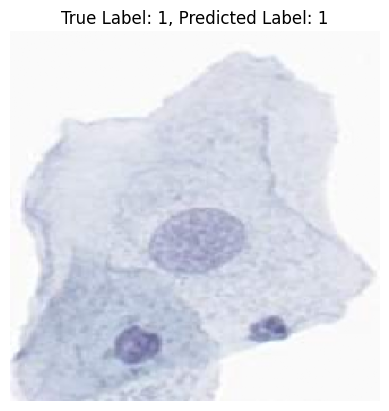

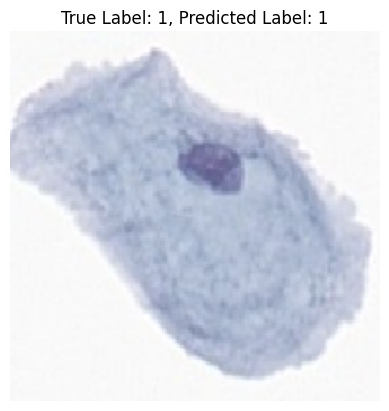

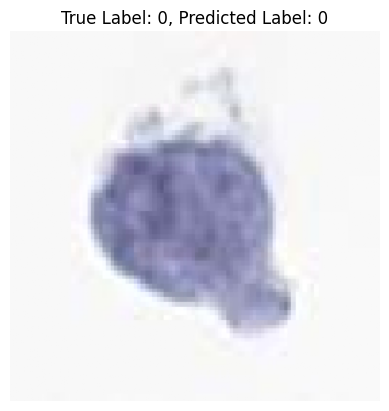

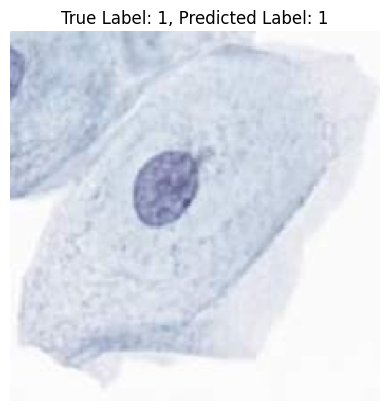

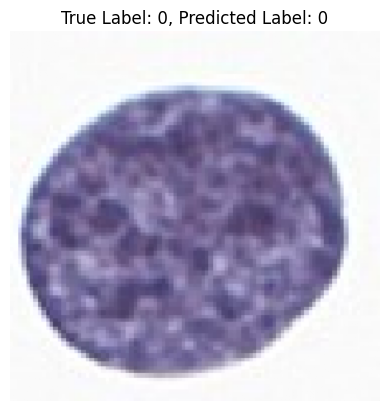

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import load_model
from keras.preprocessing import image

# Load the trained ResNet model
model_path = '/content/drive/MyDrive/moffitt/model3/model_1.h5'
model = load_model(model_path)

# Specify the testing directory
testing_dir = '/content/drive/MyDrive/moffitt/combined_testing/'

# Load the testing dataframe
full_testing_df = pd.read_csv('/content/drive/MyDrive/moffitt/full_testing_df.csv')  # Replace with the actual path

# Preprocess the testing data
test_datagen = ImageDataGenerator(rescale=1./255)
testing_set = test_datagen.flow_from_dataframe(
    dataframe=full_testing_df,
    directory=testing_dir,
    x_col="Image_Path",
    y_col="Label",
    class_mode="categorical",  # or 'binary' depending on your task
    target_size=(224, 224),  # Replace with the size used during training
    batch_size=1,
    shuffle=False  # Important: Keep the order for evaluation and confusion matrix
)

# Make predictions on the testing set
y_true = testing_set.classes
y_pred_prob = model.predict(testing_set)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate accuracy, F1 score, recall, and confusion matrix
accuracy = accuracy_score(y_true, y_pred)
classification_report_str = classification_report(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

# Print and plot the results
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report_str)

# Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Randomly pick 20 images and create a confusion matrix
random_indices = np.random.choice(len(y_true), size=20, replace=False)
random_images = [testing_set.filepaths[i] for i in random_indices]
random_labels_true = [y_true[i] for i in random_indices]
random_labels_pred = [y_pred[i] for i in random_indices]

# Display the randomly selected images with true and predicted labels
for img_path, true_label, pred_label in zip(random_images, random_labels_true, random_labels_pred):
    img = image.load_img(img_path, target_size=(224, 224))  # Replace with the size used during training
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    plt.figure()
    plt.imshow(img_array[0])
    plt.title(f'True Label: {true_label}, Predicted Label: {pred_label}')
    plt.axis('off')
    plt.show()

1: non diseases
0: diseases

Found 10436 validated image filenames belonging to 2 classes.
Found 1160 validated image filenames belonging to 2 classes.
Loaded model from /content/drive/MyDrive/moffitt/model4/model_1.h5


<ipython-input-90-aaf39a89f896>:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_test.fit_generator(


Epoch 1/10
521/521 [==============================] - 722s 1s/step - loss: 0.0251 - accuracy: 0.9911 - val_loss: 1.4148 - val_accuracy: 0.7836
Epoch 2/10
521/521 [==============================] - 676s 1s/step - loss: 0.0155 - accuracy: 0.9945 - val_loss: 0.0708 - val_accuracy: 0.9922
Epoch 3/10
521/521 [==============================] - 678s 1s/step - loss: 0.0086 - accuracy: 0.9971 - val_loss: 0.8492 - val_accuracy: 0.9181
Epoch 4/10
521/521 [==============================] - 667s 1s/step - loss: 0.0076 - accuracy: 0.9965 - val_loss: 0.0121 - val_accuracy: 0.9940
Epoch 5/10
521/521 [==============================] - 675s 1s/step - loss: 0.0068 - accuracy: 0.9985 - val_loss: 5.9488e-05 - val_accuracy: 1.0000
Epoch 6/10
521/521 [==============================] - 699s 1s/step - loss: 0.0062 - accuracy: 0.9984 - val_loss: 1.9327 - val_accuracy: 0.8983
Epoch 7/10
521/521 [==============================] - 677s 1s/step - loss: 0.0101 - accuracy: 0.9967 - val_loss: 2.8888 - val_accuracy: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


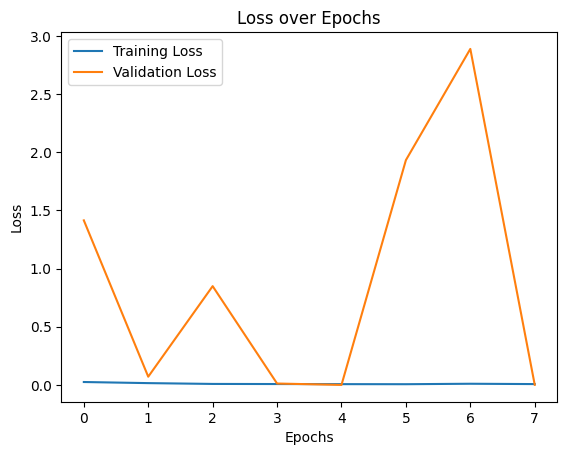

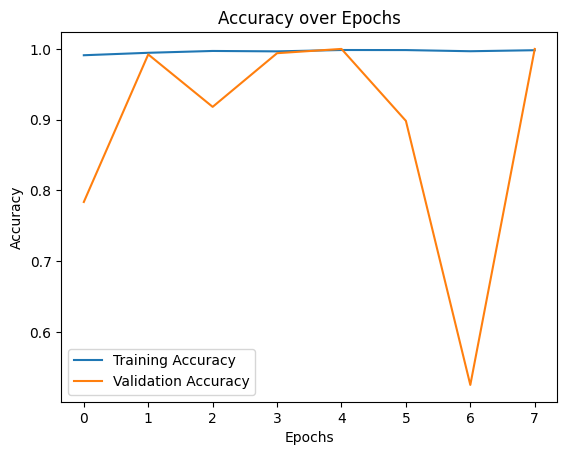

Found 10436 validated image filenames belonging to 2 classes.
Found 1160 validated image filenames belonging to 2 classes.
Loaded model from /content/drive/MyDrive/moffitt/model4/model_2.h5


<ipython-input-90-aaf39a89f896>:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_test.fit_generator(


Epoch 1/10
 60/521 [==>...........................] - ETA: 9:11 - loss: 2.8820 - accuracy: 0.5633

KeyboardInterrupt: 

In [ ]:
from keras.models import load_model

# ... (previous code)
from keras.callbacks import EarlyStopping

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

# Specify the directory to save and load the models
save_dir = '/content/drive/MyDrive/moffitt/model4/'

# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
os.makedirs('/content/drive/MyDrive/moffitt/model5/')

kfold = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=42)

# Variable to keep track of the model number
j = 1

for train_idx, val_idx in list(kfold.split(train_x, train_y)):
    # ... (previous code)
    x_train_df = df.iloc[train_idx]
    x_valid_df = df.iloc[val_idx]

    training_set = train_datagen.flow_from_dataframe(dataframe=x_train_df, directory=TRAIN_PATH,
                                                     x_col="Image_Path", y_col="Label",
                                                     class_mode="categorical",
                                                     target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

    validation_set = validation_datagen.flow_from_dataframe(dataframe=x_valid_df, directory=TRAIN_PATH,
                                                           x_col="Image_Path", y_col="Label",
                                                           class_mode="categorical",
                                                           target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

    # Check if there's a previously saved model to load
    model_path = f"{save_dir}model_{j}.h5"
    if os.path.exists(model_path):
        # Load the model
        model_test = load_model(model_path)
        print(f"Loaded model from {model_path}")
    else:
        # If no saved model is found, create a new one
        model_test = get_model(IMG_SIZE)

    # EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Model training
    history = model_test.fit_generator(
        training_set,
        validation_data=validation_set,
        epochs=EPOCHS,
        steps_per_epoch=x_train_df.shape[0] // BATCH_SIZE,
        callbacks=[early_stopping]  # Add the EarlyStopping callback
    )

    # Save the model
    model_test.save(f"/content/drive/MyDrive/moffitt/model5/model_{j}.h5")

    # Plot loss and accuracy
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    j += 1


Found 2609 validated image filenames belonging to 2 classes.
Found 290 validated image filenames belonging to 2 classes.
Loaded model from /content/drive/MyDrive/moffitt/model7/model_1.h5


<ipython-input-32-cb459ed643e9>:54: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_test.fit_generator(


Epoch 1/10
130/130 [==============================] - 191s 1s/step - loss: 0.0999 - accuracy: 0.9714 - val_loss: 0.0764 - val_accuracy: 0.9793
Epoch 2/10
130/130 [==============================] - 173s 1s/step - loss: 0.0956 - accuracy: 0.9730 - val_loss: 0.1005 - val_accuracy: 0.9690
Epoch 3/10
130/130 [==============================] - 170s 1s/step - loss: 0.0721 - accuracy: 0.9784 - val_loss: 0.0678 - val_accuracy: 0.9759
Epoch 4/10
130/130 [==============================] - 180s 1s/step - loss: 0.0881 - accuracy: 0.9745 - val_loss: 0.0689 - val_accuracy: 0.9793
Epoch 5/10
130/130 [==============================] - 175s 1s/step - loss: 0.0979 - accuracy: 0.9703 - val_loss: 0.0808 - val_accuracy: 0.9759
Epoch 6/10
130/130 [==============================] - 175s 1s/step - loss: 0.0926 - accuracy: 0.9722 - val_loss: 0.0683 - val_accuracy: 0.9828


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


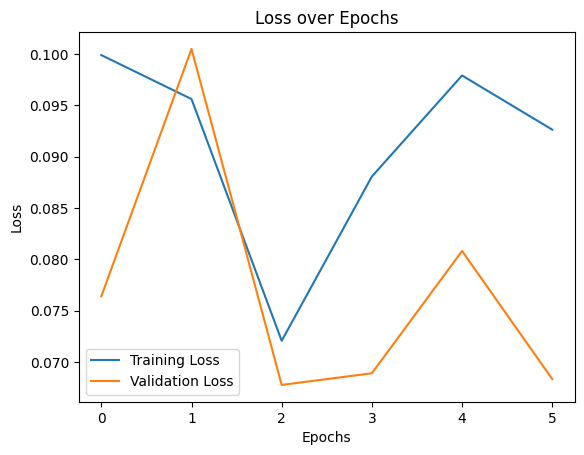

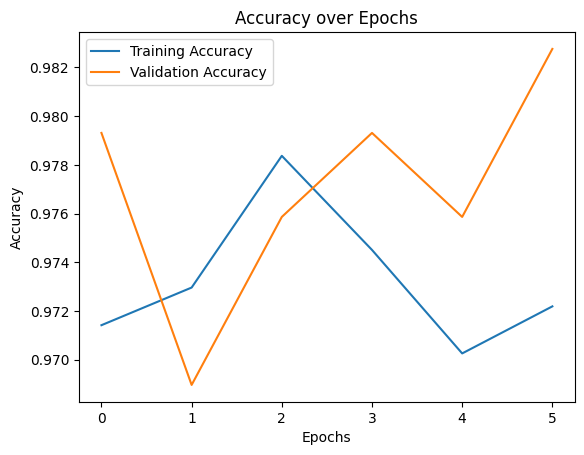

Found 2609 validated image filenames belonging to 2 classes.
Found 290 validated image filenames belonging to 2 classes.
94765736/94765736 [==============================] - 1s 0us/step


<ipython-input-32-cb459ed643e9>:54: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_test.fit_generator(


Epoch 1/10


KeyboardInterrupt: 

In [ ]:
from keras.models import load_model

# ... (previous code)

from keras.callbacks import EarlyStopping

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)
# Specify the directory to save and load the models
save_dir = '/content/drive/MyDrive/moffitt/model7/'

# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

kfold = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=42)

# Variable to keep track of the model number
j = 1

for train_idx, val_idx in list(kfold.split(train_x, train_y)):
    # ... (previous code)
    x_train_df = df.iloc[train_idx]
    x_valid_df = df.iloc[val_idx]

    training_set = train_datagen.flow_from_dataframe(dataframe=x_train_df, directory=TRAIN_PATH,
                                                     x_col="Image_Path", y_col="Label",
                                                     class_mode="categorical",
                                                     target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

    validation_set = validation_datagen.flow_from_dataframe(dataframe=x_valid_df, directory=TRAIN_PATH,
                                                           x_col="Image_Path", y_col="Label",
                                                           class_mode="categorical",
                                                           target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

    # Check if there's a previously saved model to load
    model_path = f"{save_dir}model_{j}.h5"
    if os.path.exists(model_path):
        # Load the model
        model_test = load_model(model_path)
        print(f"Loaded model from {model_path}")
    else:
        # If no saved model is found, create a new one
        model_test = get_model(IMG_SIZE)

    # EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Model training
    history = model_test.fit_generator(
        training_set,
        validation_data=validation_set,
        epochs=EPOCHS,
        steps_per_epoch=x_train_df.shape[0] // BATCH_SIZE,
        callbacks=[early_stopping]  # Add the EarlyStopping callback
    )

    # Save the model
    model_test.save(f"/content/drive/MyDrive/moffitt/model7/model_{j}.h5")

    # Plot loss and accuracy
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    j += 1

Found 156 validated image filenames belonging to 2 classes.
156/156 [==============================] - 71s 440ms/step
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00      1.00      1.00        80

    accuracy                           1.00       156
   macro avg       1.00      1.00      1.00       156
weighted avg       1.00      1.00      1.00       156



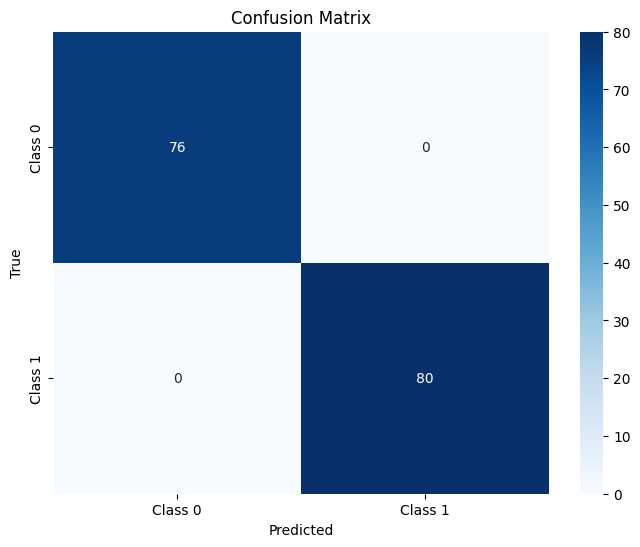

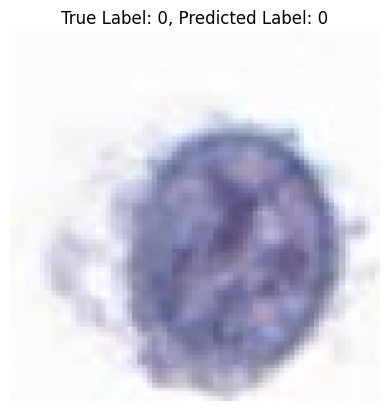

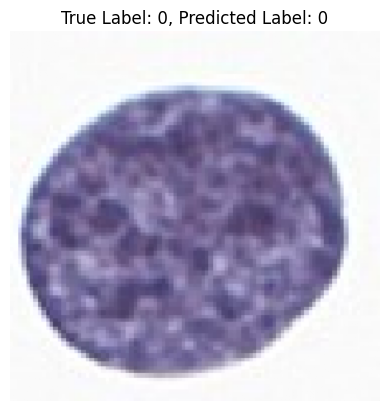

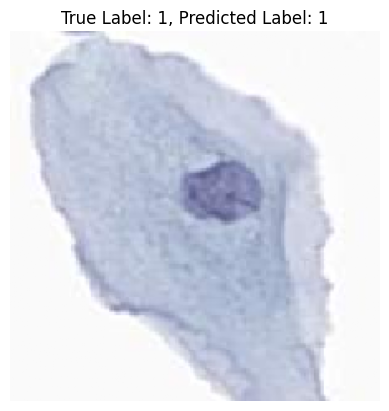

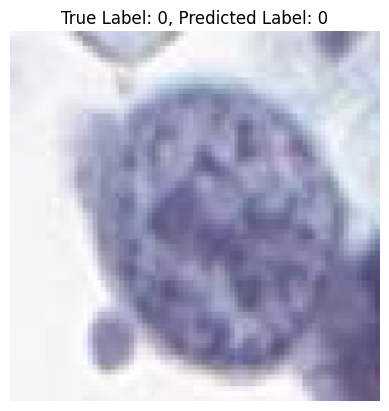

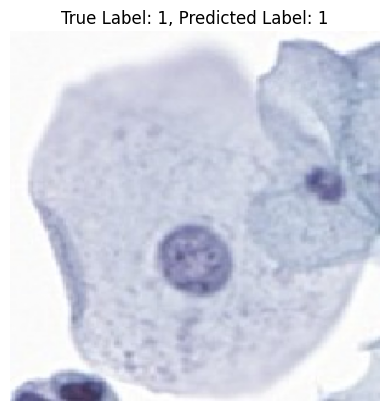

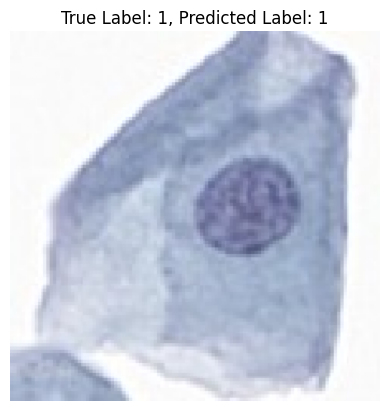

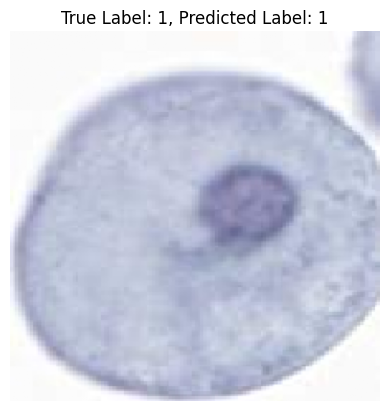

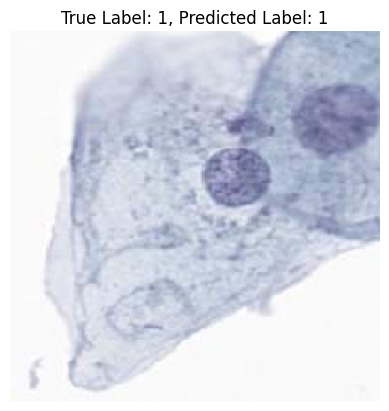

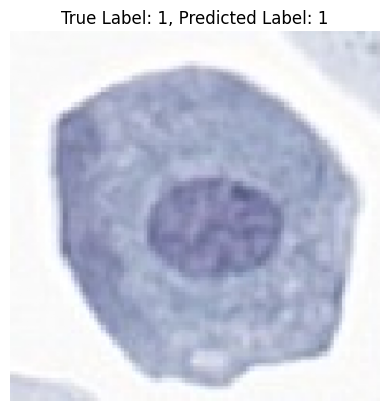

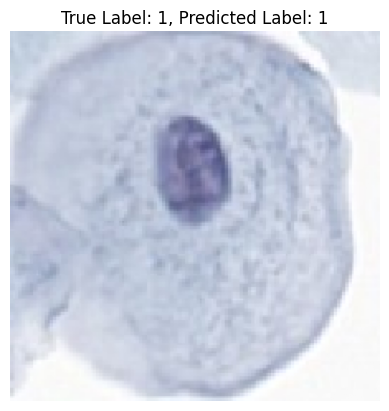

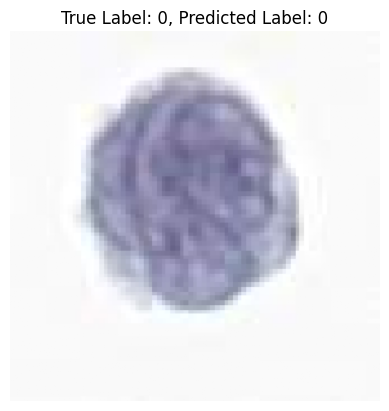

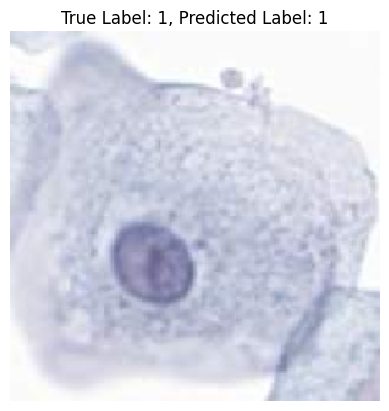

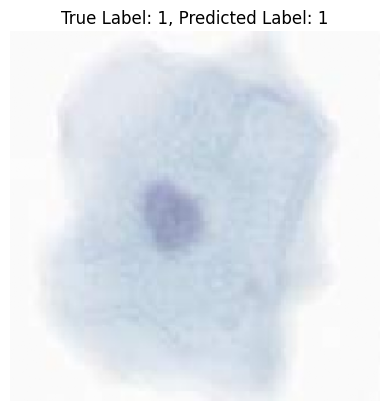

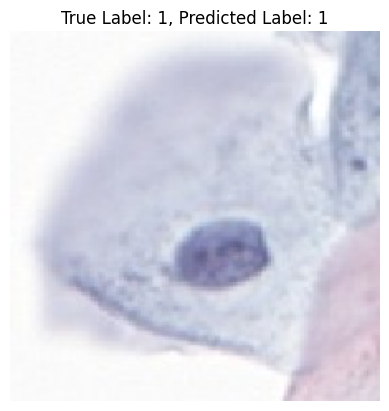

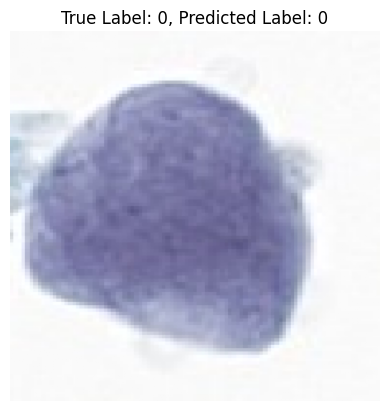

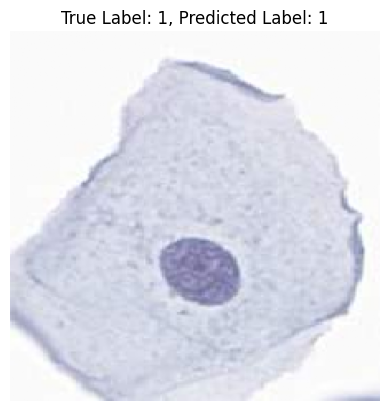

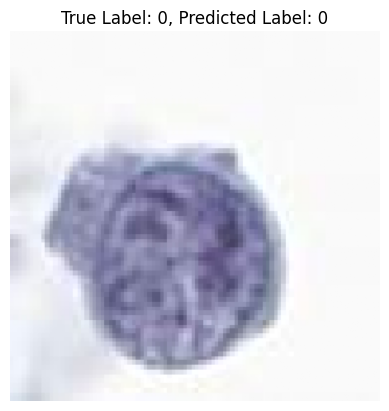

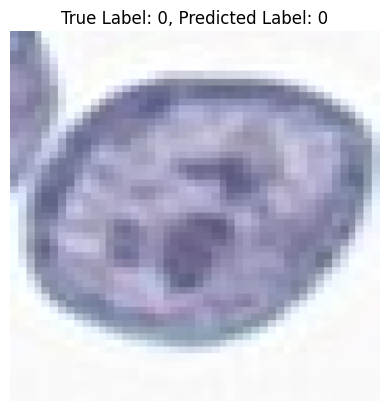

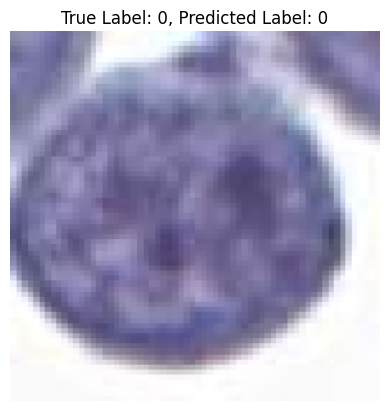

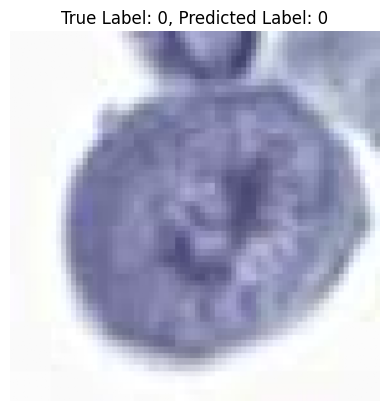

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import load_model
from keras.preprocessing import image

# Load the trained ResNet model
model_path = '/content/drive/MyDrive/moffitt/model5/model_1.h5'
model = load_model(model_path)

# Specify the testing directory
testing_dir = '/content/drive/MyDrive/moffitt/combined_testing/'

# Load the testing dataframe
full_testing_df = pd.read_csv('/content/drive/MyDrive/moffitt/full_testing_df.csv')  # Replace with the actual path

# Preprocess the testing data
test_datagen = ImageDataGenerator(rescale=1./255)
testing_set = test_datagen.flow_from_dataframe(
    dataframe=full_testing_df,
    directory=testing_dir,
    x_col="Image_Path",
    y_col="Label",
    class_mode="categorical",  # or 'binary' depending on your task
    target_size=(224, 224),  # Replace with the size used during training
    batch_size=1,
    shuffle=False  # Important: Keep the order for evaluation and confusion matrix
)

# Make predictions on the testing set
y_true = testing_set.classes
y_pred_prob = model.predict(testing_set)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate accuracy, F1 score, recall, and confusion matrix
accuracy = accuracy_score(y_true, y_pred)
classification_report_str = classification_report(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

# Print and plot the results
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report_str)

# Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Randomly pick 20 images and create a confusion matrix
random_indices = np.random.choice(len(y_true), size=20, replace=False)
random_images = [testing_set.filepaths[i] for i in random_indices]
random_labels_true = [y_true[i] for i in random_indices]
random_labels_pred = [y_pred[i] for i in random_indices]

# Display the randomly selected images with true and predicted labels
for img_path, true_label, pred_label in zip(random_images, random_labels_true, random_labels_pred):
    img = image.load_img(img_path, target_size=(224, 224))  # Replace with the size used during training
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    plt.figure()
    plt.imshow(img_array[0])
    plt.title(f'True Label: {true_label}, Predicted Label: {pred_label}')
    plt.axis('off')
    plt.show()

Found 156 validated image filenames belonging to 2 classes.
156/156 [==============================] - 139s 876ms/step
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00      1.00      1.00        80

    accuracy                           1.00       156
   macro avg       1.00      1.00      1.00       156
weighted avg       1.00      1.00      1.00       156



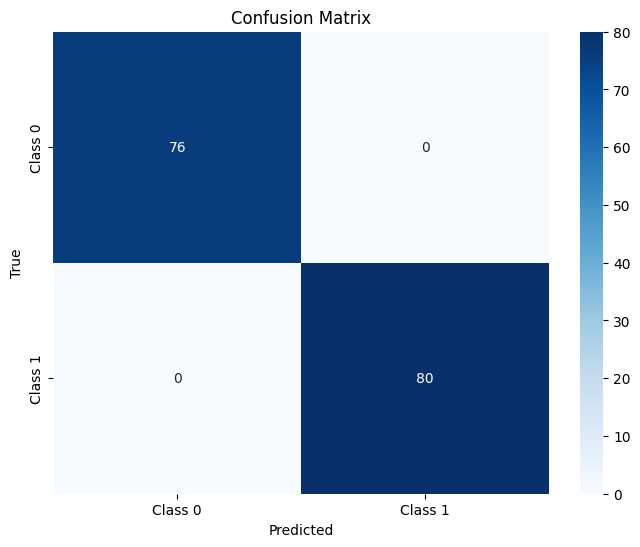

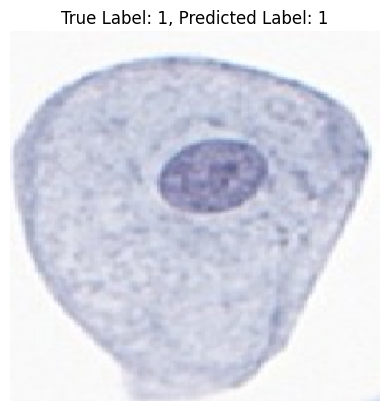

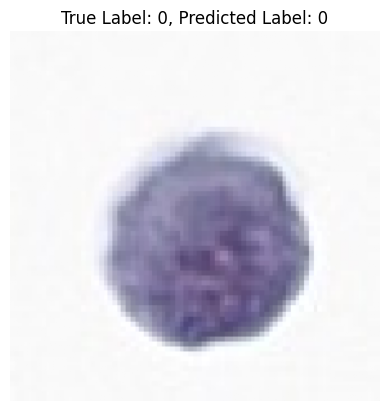

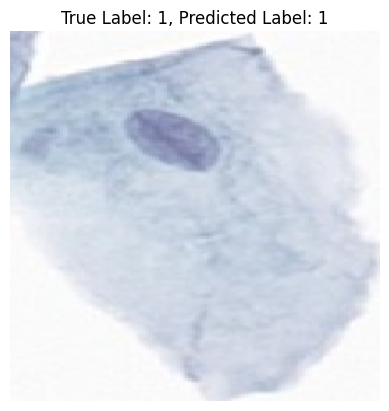

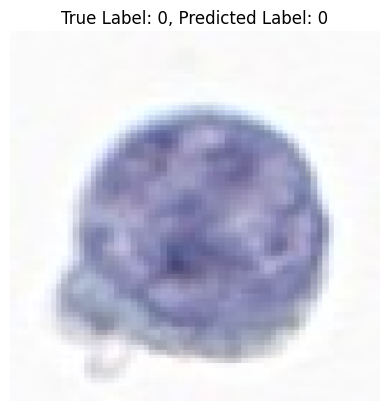

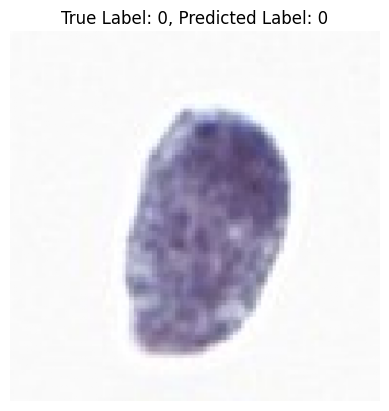

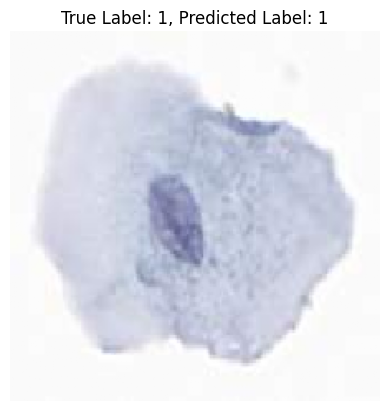

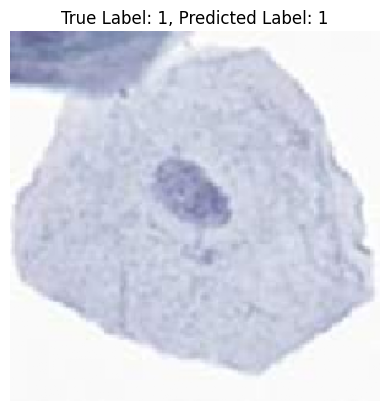

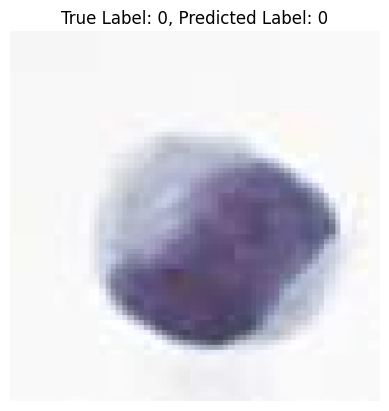

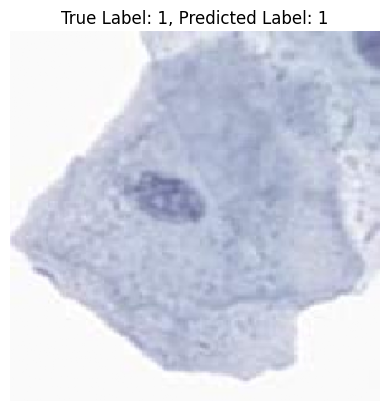

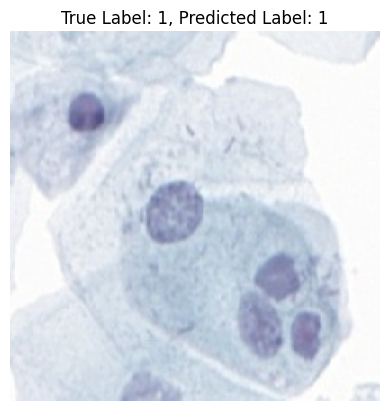

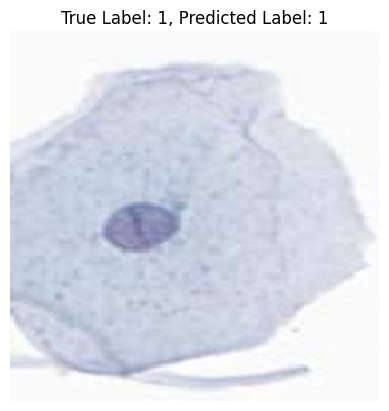

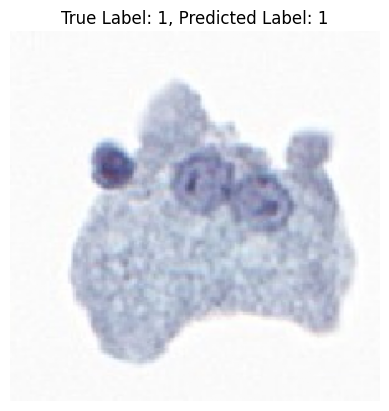

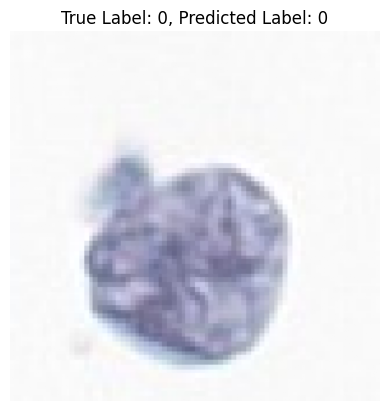

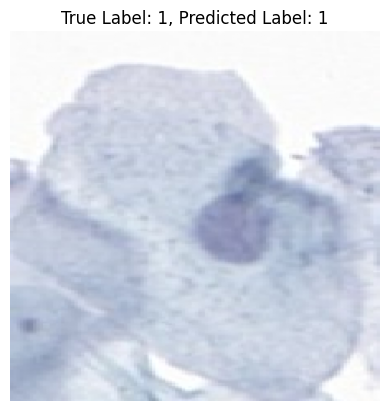

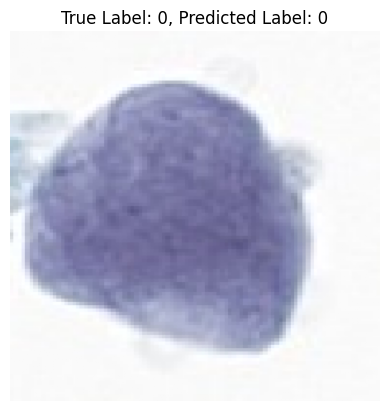

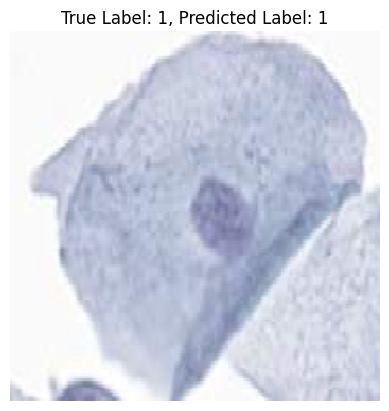

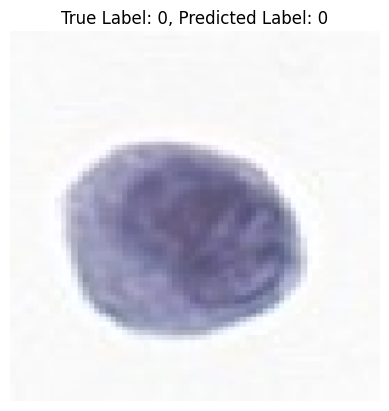

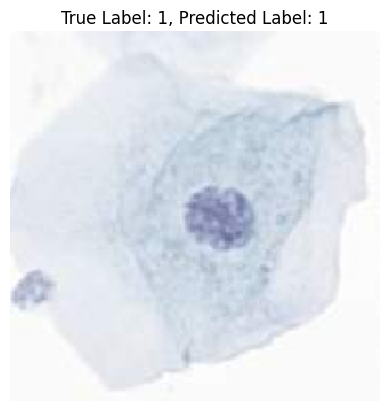

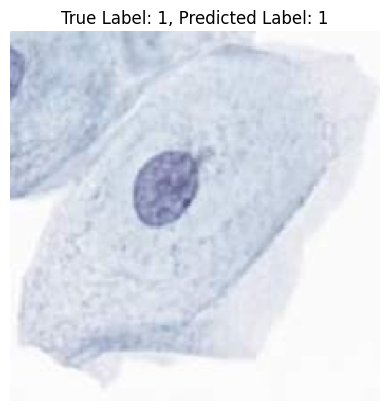

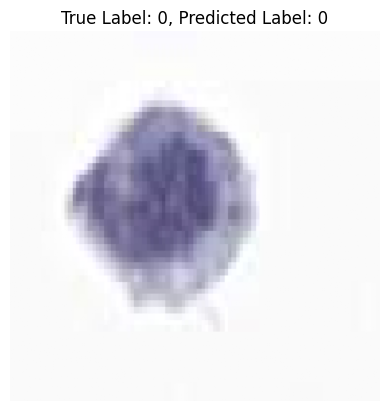

In [6]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import load_model
from keras.preprocessing import image

# Load the trained ResNet model
model_path = '/content/drive/MyDrive/moffitt/model7/model_1.h5'
model = load_model(model_path)

# Specify the testing directory
testing_dir = '/content/drive/MyDrive/moffitt/combined_testing/'

# Load the testing dataframe
full_testing_df = pd.read_csv('/content/drive/MyDrive/moffitt/full_testing_df.csv')  # Replace with the actual path

# Preprocess the testing data
test_datagen = ImageDataGenerator(rescale=1./255)
testing_set = test_datagen.flow_from_dataframe(
    dataframe=full_testing_df,
    directory=testing_dir,
    x_col="Image_Path",
    y_col="Label",
    class_mode="categorical",  # or 'binary' depending on your task
    target_size=(224, 224),  # Replace with the size used during training
    batch_size=1,
    shuffle=False  # Important: Keep the order for evaluation and confusion matrix
)

# Make predictions on the testing set
y_true = testing_set.classes
y_pred_prob = model.predict(testing_set)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate accuracy, F1 score, recall, and confusion matrix
accuracy = accuracy_score(y_true, y_pred)
classification_report_str = classification_report(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

# Print and plot the results
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report_str)

# Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Randomly pick 20 images and create a confusion matrix
random_indices = np.random.choice(len(y_true), size=20, replace=False)
random_images = [testing_set.filepaths[i] for i in random_indices]
random_labels_true = [y_true[i] for i in random_indices]
random_labels_pred = [y_pred[i] for i in random_indices]

# Display the randomly selected images with true and predicted labels
for img_path, true_label, pred_label in zip(random_images, random_labels_true, random_labels_pred):
    img = image.load_img(img_path, target_size=(224, 224))  # Replace with the size used during training
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    plt.figure()
    plt.imshow(img_array[0])
    plt.title(f'True Label: {true_label}, Predicted Label: {pred_label}')
    plt.axis('off')
    plt.show()

In [7]:
import numpy as np
from keras.preprocessing import image

def predict_single_image(model, image_path):
    # Load and preprocess the input image
    img = image.load_img(image_path, target_size=(224, 224))  # Replace with the size used during training
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Make prediction using the loaded model
    prediction_prob = model.predict(img_array)
    predicted_class = np.argmax(prediction_prob, axis=1)[0]

    return predicted_class, prediction_prob[0]

# Example usage:
user_image_path = 'no_diseasesT.jpg'  # Replace with the actual path
predicted_class, prediction_prob = predict_single_image(model, user_image_path)

# Display the result
print(f'Predicted Class: {predicted_class}')
print(f'Prediction Probabilities: {prediction_prob}')


1/1 [==============================] - 1s 1s/step
Predicted Class: 1
Prediction Probabilities: [0.10385466 0.85670406]
